<a href="https://colab.research.google.com/github/halaBelmo/ProjetML/blob/main/Copy_of_Iot_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

uploaded = files.upload()


Saving ai4i2020.csv to ai4i2020.csv


In [ ]:

df = pd.read_csv('ai4i2020.csv')
#print(df.head())
#print(df.info())


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 2. Preprocessing
# Drop useless columns (ID) and leakage columns (Failure Types)
df = df.drop(columns=['UDI', 'Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], errors='ignore')

y = df['Machine failure']
X = df.drop(columns=['Machine failure'], errors='ignore')

# 3. Scaling (Important for SVM and KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



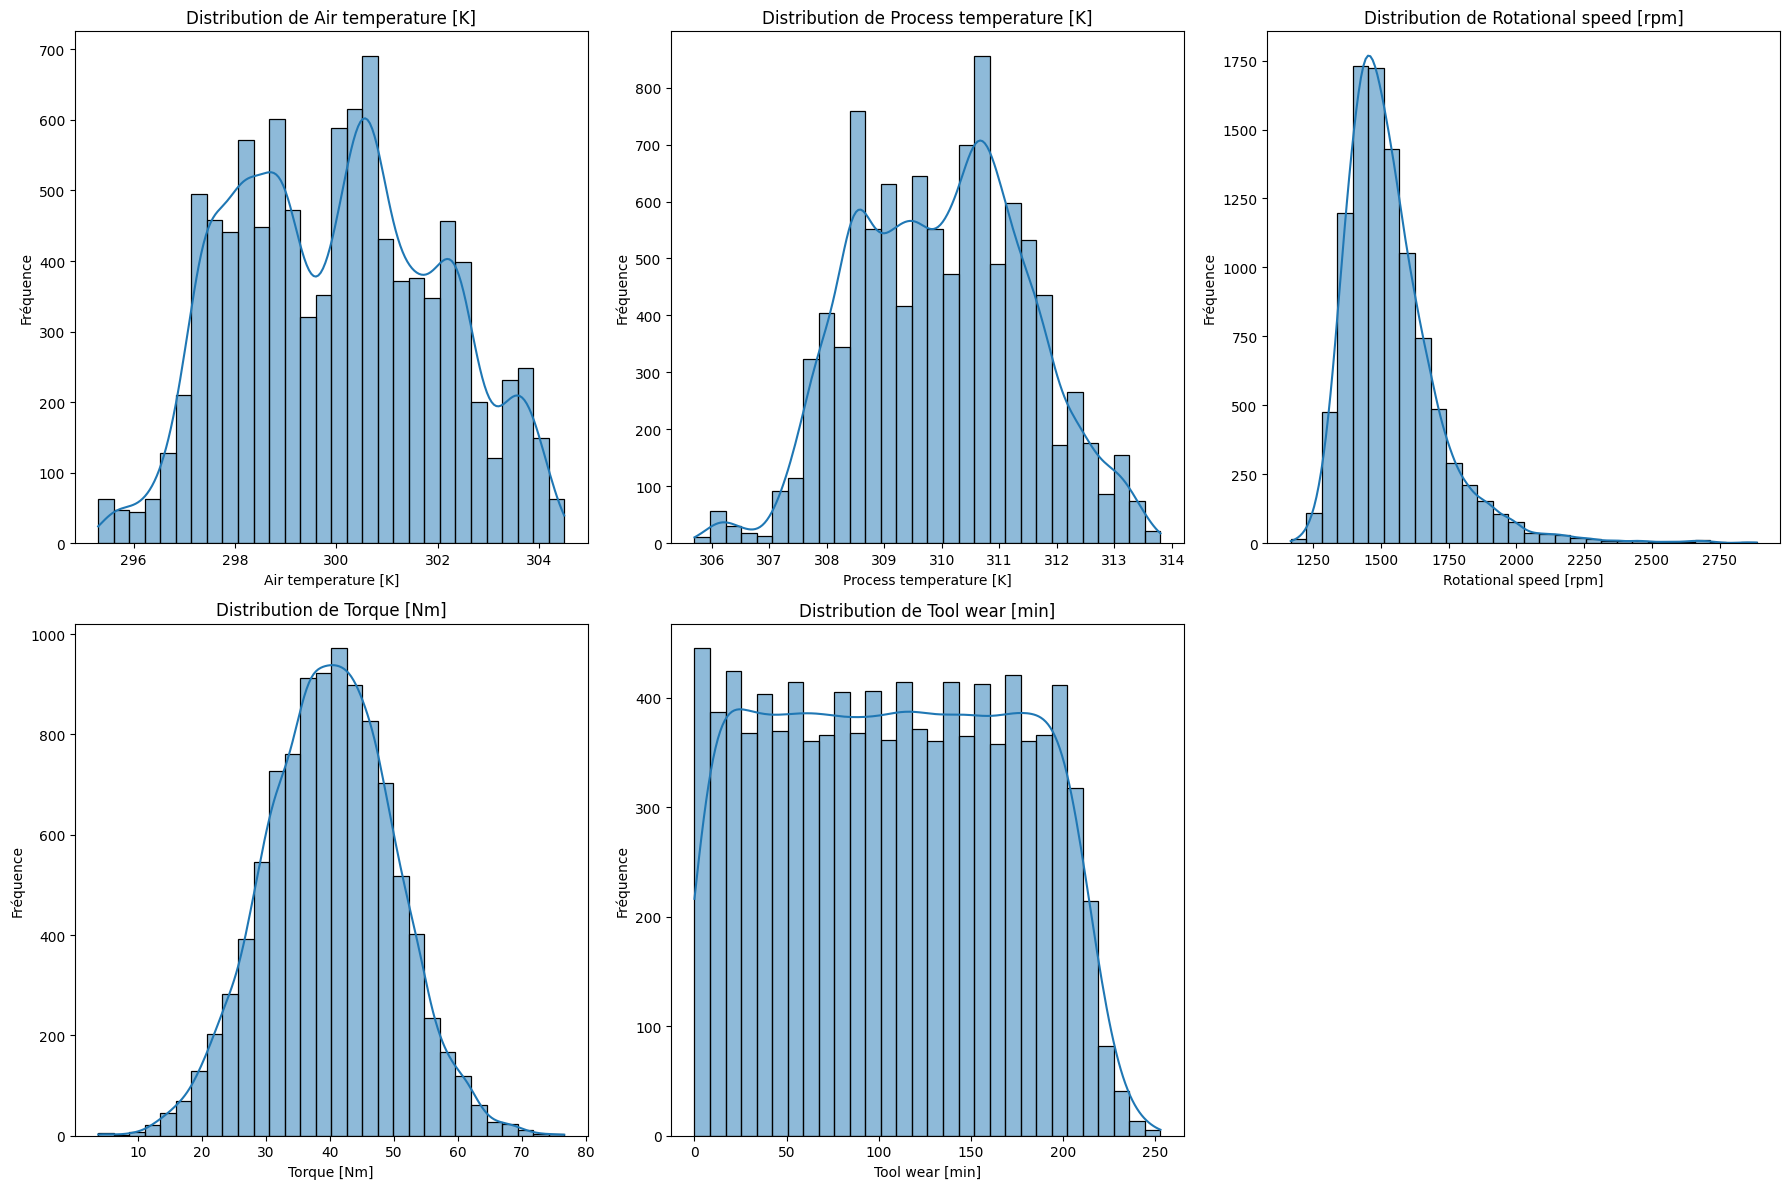

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

plt.figure(figsize=(18, 12))

for i, col in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion - {model_name}")
    plt.ylabel('Réel')
    plt.xlabel('Prédit')
    plt.show()

def print_model_scores(model_name, y_true, y_pred):
    print(f"--- Scores pour {model_name} ---")
    print(classification_report(y_true, y_pred))
    print("\n")

def plot_learning_curve(model, X, y, model_name="Modèle"):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Score sur train')
    plt.plot(train_sizes, test_mean, 'o-', color='red', label='Score sur validation')
    plt.title(f"Courbe d’apprentissage - {model_name}")
    plt.xlabel("Taille de l’échantillon d’entraînement")
    plt.ylabel("F1-score")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
# --- A. INITIAL DECISION TREE ---
# (We must train it befoe we predict with it)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)  # travaille par ce que le modele est traine

#print("--- Initial Decision Tree ---")
#print(classification_report(y_test, y_pred_dt))

#PTIMIZED DECISION TREE (GridSearch)
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)



#SAFETY-FIRST TREE (High Recall)
safety_tree = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)
safety_tree.fit(X_train, y_train)
y_pred_safety = safety_tree.predict(X_test)


#SVM
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)


#KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)




--- Scores pour Decision Tree ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.66      0.75      0.70        61

    accuracy                           0.98      2000
   macro avg       0.82      0.87      0.85      2000
weighted avg       0.98      0.98      0.98      2000





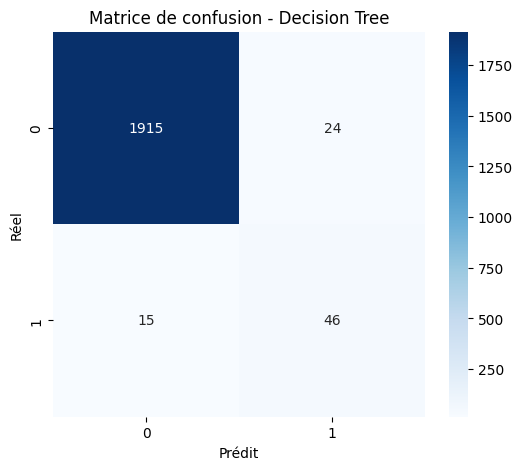

--- Scores pour SVM ---
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1939
           1       0.26      0.90      0.40        61

    accuracy                           0.92      2000
   macro avg       0.63      0.91      0.68      2000
weighted avg       0.97      0.92      0.94      2000





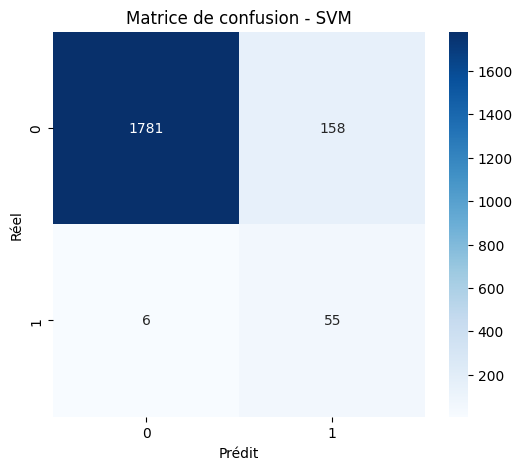

--- Scores pour KNN ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.76      0.36      0.49        61

    accuracy                           0.98      2000
   macro avg       0.87      0.68      0.74      2000
weighted avg       0.97      0.98      0.97      2000





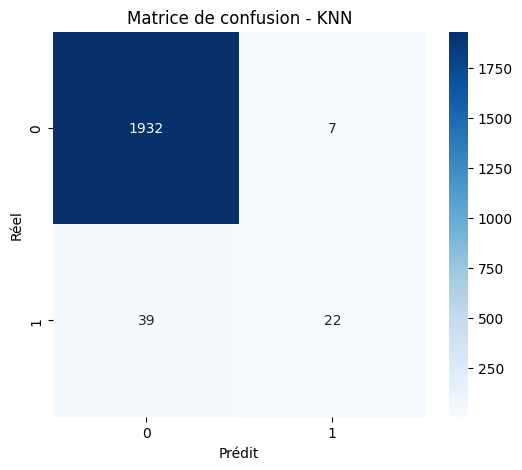

In [ ]:
# Decision Tree
print_model_scores("Decision Tree", y_test, y_pred_dt)
plot_confusion("Decision Tree", y_test, y_pred_dt)

# SVM
print_model_scores("SVM", y_test, y_pred_svm)
plot_confusion("SVM", y_test, y_pred_svm)

# KNN
print_model_scores("KNN", y_test, y_pred_knn)
plot_confusion("KNN", y_test, y_pred_knn)


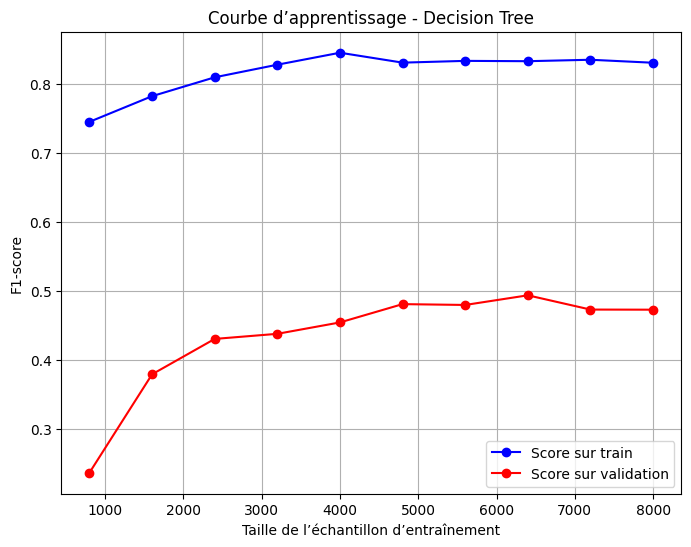

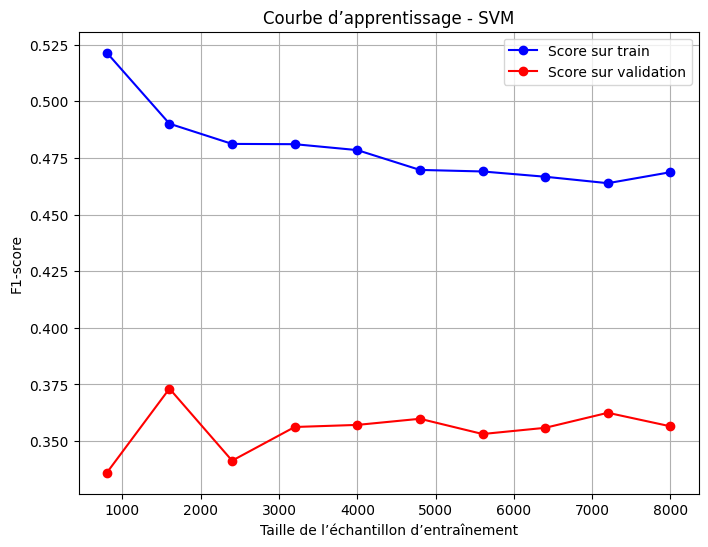

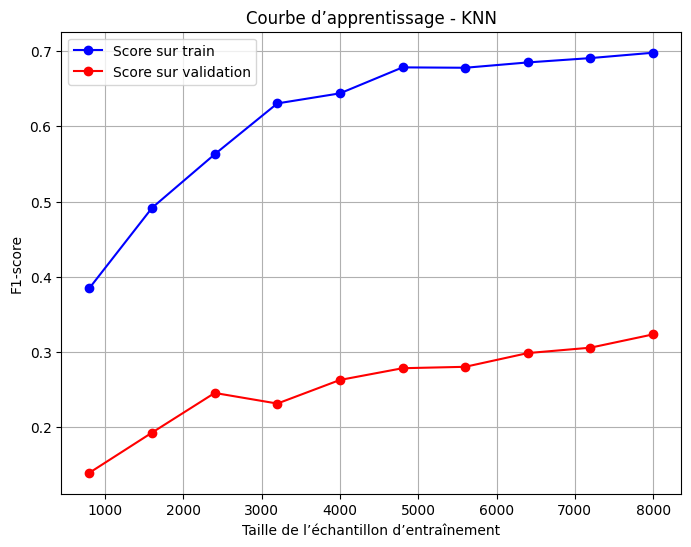

In [ ]:
plot_learning_curve(best_tree, X_scaled, y, "Decision Tree")
plot_learning_curve(svm_model, X_scaled, y, "SVM")
plot_learning_curve(knn_model, X_scaled, y, "KNN")